In [10]:
import sys
sys.path.append("..")
from flame_analysis_model import *

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import SpectralEmbedding, TSNE, MDS

import torch
import torch.optim as optim
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
if device.type == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

Using device: cuda
GPU: NVIDIA GeForce RTX 3050 4GB Laptop GPU


## Read data

In [12]:
df = pd.read_csv("flame_front_po_post0.csv")
print(df.keys())
# Select meaningful physical variables
features = ['v', 'T', 'u', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2' ]

X = StandardScaler().fit_transform(df[features])
c = X[:, 5]

Index(['x', 'y', 'u', 'v', 'T', 'c', 'dudx', 'dudy', 'dvdx', 'dvdy', 'H2',
       'O2', 'H2O', 'H', 'O', 'OH', 'HO2', 'H2O2', 'N2', 'omega_H2',
       'omega_O2', 'omega_H2O', 'omega_H', 'omega_O', 'omega_OH', 'omega_HO2',
       'omega_H2O2', 'omega_N2', 'Le_def'],
      dtype='object')


## UMAP

In [13]:
# # UMAP embedding
# reducer = umap.UMAP(n_neighbors=10, n_components=2)
# X_embedded = reducer.fit_transform(X)
# # Plot
# plt.scatter(X_embedded[:,0], X_embedded[:,1],c=c, cmap='viridis', s=10)
# plt.title("UMAP")
# plt.xlabel("UMAP-1")
# plt.ylabel("UMAP-2")
# plt.show()

## Spectral Embedding

In [14]:
# SE = SpectralEmbedding(n_components=2, n_neighbors=30)
# X_SE = SE.fit_transform(X)
# # Plot
# plt.scatter(X_SE[:,0], X_SE[:,1],c=c, cmap='viridis', s=10)
# plt.title("Spectral Embedding")
# plt.xlabel("SE-1")
# plt.ylabel("SE-2")
# plt.show()

## t-SNE

In [15]:
# t_sne = TSNE(
#     n_components=2,
#     perplexity=30,
#     init="random",
#     max_iter=250,
#     random_state=0,
# )
# X_sne = t_sne.fit_transform(X)
#
# plt.scatter(X_sne[:,0], X_sne[:,1],c=c, cmap='viridis', s=10)
# plt.title("t_SNE")
# plt.xlabel("t_SNE-1")
# plt.ylabel("t_SNE-2")
# plt.show()


## Multidimensional Scaling

In [16]:
# MDS = MDS(n_components=2, n_init=1)
# X_mds = MDS.fit_transform(X)
#
# plt.scatter(X_mds[:,0], X_mds[:,1],c=c, cmap='viridis', s=10)
# plt.title("MDS")
# plt.xlabel("MDS-1")
# plt.ylabel("MDS-2")
# plt.show()


## Autoencoder

In [17]:
num_points, D_orig = X.shape
num_latent = 5
num_hidden = 30

model = AutoEncoder(D_orig, num_latent, num_hidden).to(device)

num_params = sum(p.numel() for p in model.parameters())
print(f"Parameters: {num_params:,} (~{num_params*4/1e6:.2f} MB)")

optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-2
)
criterion = nn.MSELoss()

Parameters: 2,914 (~0.01 MB)


In [18]:
# Dataset & Loader
from torch.utils.data import DataLoader, TensorDataset
X_torch = torch.from_numpy(X).float()
dataset = TensorDataset(X_torch)
loader = DataLoader(dataset, batch_size=1024, shuffle=True)

# Training loop
epochs = 10_000

from torch import amp
torch.backends.cudnn.benchmark = True

scaler = amp.GradScaler("cuda")

for epoch in range(epochs):
    running_loss = 0.0
    for (batch,) in loader:
        batch = batch.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        with amp.autocast("cuda"):                # new API
            decoded, encoded = model(batch)
            loss = criterion(decoded, batch)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * batch.size(0)

    epoch_loss = running_loss / len(dataset)
    if epoch % 500 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] - Loss: {epoch_loss:.6f}")



Epoch [1/10000] - Loss: 3529.235899
Epoch [501/10000] - Loss: 0.702371
Epoch [1001/10000] - Loss: 0.430545
Epoch [1501/10000] - Loss: 0.431240
Epoch [2001/10000] - Loss: 0.422449
Epoch [2501/10000] - Loss: 0.452683
Epoch [3001/10000] - Loss: 0.406278
Epoch [3501/10000] - Loss: 0.399670
Epoch [4001/10000] - Loss: 0.345948
Epoch [4501/10000] - Loss: 0.208829
Epoch [5001/10000] - Loss: 0.109636
Epoch [5501/10000] - Loss: 0.104436
Epoch [6001/10000] - Loss: 0.107672
Epoch [6501/10000] - Loss: 0.108561
Epoch [7001/10000] - Loss: 0.108073
Epoch [7501/10000] - Loss: 0.108446
Epoch [8001/10000] - Loss: 0.109878
Epoch [8501/10000] - Loss: 0.107184
Epoch [9001/10000] - Loss: 0.106280
Epoch [9501/10000] - Loss: 0.111385


In [19]:
X_torch_gpu = X_torch.to(device)
decoded, encoded = model(X_torch_gpu)

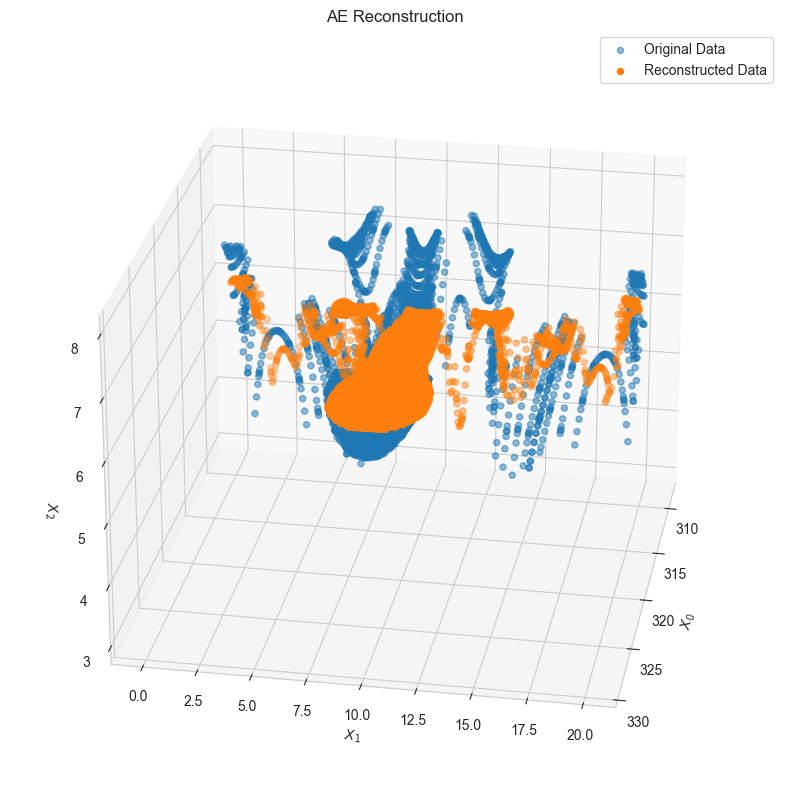

In [20]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
X_P = decoded.detach().cpu().numpy()

ax.scatter(X[:,0], X[:,1], X[:,2],alpha=0.5)
ax.scatter(X_P[:,0], X_P[:,1], X_P[:,2])
ax.set_xlabel('$X_0$')
ax.set_ylabel('$X_1$')
ax.set_zlabel('$X_2$')
ax.elev=25
ax.azim=10
plt.legend(['Original Data','Reconstructed Data'])
plt.title("AE Reconstruction")
plt.show()

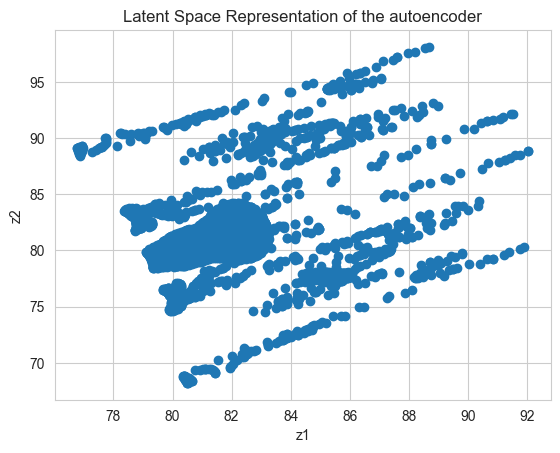

In [21]:
Z = encoded.cpu().detach().numpy()
# Only works if num_latent >=2
if num_latent>=2:
    plt.figure()
    plt.scatter(Z[:,0],Z[:,1])
    plt.xlabel('z1')
    plt.ylabel('z2')
    plt.title('Latent Space Representation of the autoencoder')
    plt.show()

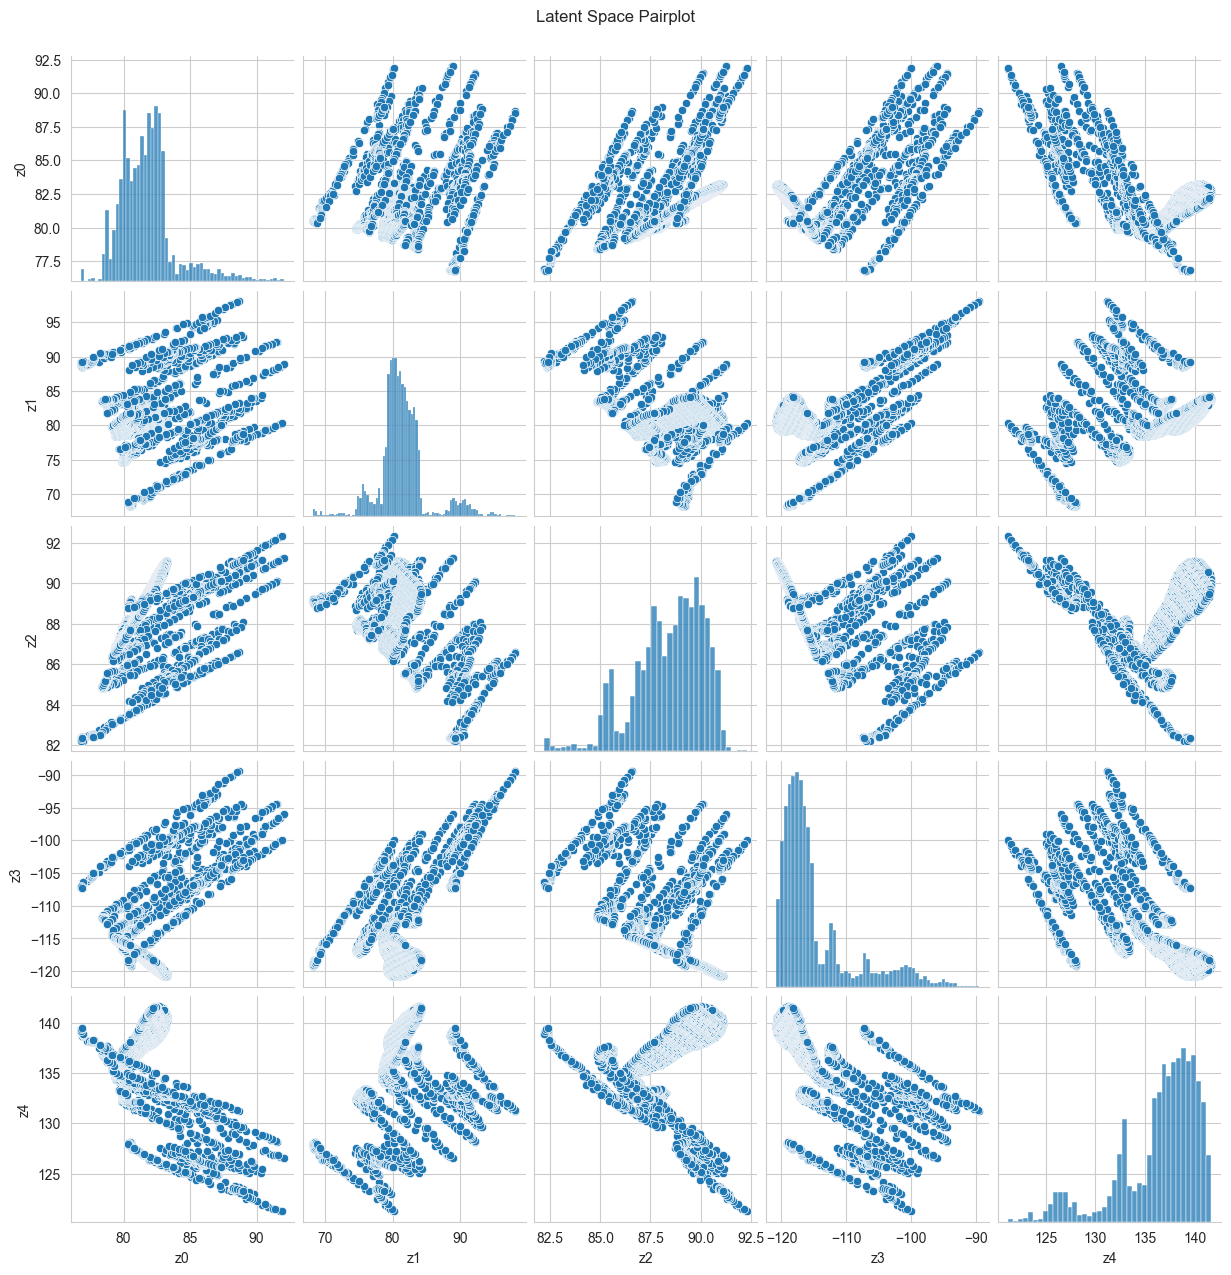

In [22]:
df_latent = pd.DataFrame(Z, columns=[f'z{i}' for i in range(Z.shape[1])])
sns.pairplot(df_latent)
plt.suptitle('Latent Space Pairplot', y=1.02)
plt.show()

## Least Volume Regularization

In [23]:
# #| code-fold: false
# ambient_dim = X.shape[1]
#
# # Change the below latent dimension to see what happens to the embedded points
# latent_dim = 3
#
# width = ambient_dim * 16
# encoder = MLP(ambient_dim, latent_dim, [width] * 4)
# decoder = MLP(latent_dim, ambient_dim, [width] * 4)
#
# opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-4)
#
# #| code-fold: false
# # Set X to a torch tensor:
# X_torch = torch.from_numpy(X).float()
#
# for i in range(5000):
#     opt.zero_grad()
#     z = encoder(X_torch)
#     rec_loss = F.mse_loss(decoder(z), X_torch)
#     loss = rec_loss
#     # If you want, you can even add an L1 penalty on the latent space
#     # to try to encourage sparsity by uncommenting the line below:
#     #loss += 1e-3 * torch.mean(torch.abs(z))
#
#     loss.backward()
#     opt.step()
#     if (i+1) % 100 == 0:
#         print(f'Epoch {i:4}: rec = {rec_loss:.5g}')

In [24]:
# encoder.eval()
# decoder.eval()
#
# # Embed the data into Z using the trained encoder
# with torch.no_grad():
#     z = encoder(X_torch)
#     X_P = decoder(encoder(X_torch)).detach().numpy()
# # Now let's sort the latent codes by which ones have the
# # largest standard deviation in Z:
#
# import matplotlib.pyplot as plt
#
#
# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(111, projection='3d')
#
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.5, label='Original Data')
# ax.scatter(X_P[:, 0], X_P[:, 1], X_P[:, 2], alpha=0.5, label='Reconstructed Data')
#
# ax.set_xlabel('$X_0$')
# ax.set_ylabel('$X_1$')
# ax.set_zlabel('$X_2$')
# ax.view_init(elev=25, azim=10)
# ax.legend()
# plt.title("AE Reconstruction")
# plt.show()


In [25]:
# idx = z.std(0).argsort(descending=True)
#
# plt.figure()
# plt.bar(np.arange(z.std(0).size(-1)), z.std(0)[idx])
# plt.title('latent STDs (autoencoder)')
# plt.show()
#
# plt.figure()
# plt.scatter(z[:, idx[0]].cpu().detach().numpy(), z[:, idx[1]].cpu().detach().numpy(), s=10)
# plt.gca().set_aspect('equal')
# plt.xlabel('$z_0$')
# plt.ylabel('$z_1$')
# plt.show()

## Least Volume  but slighlty different?

In [26]:

# #| code-fold: false
# width = ambient_dim * 16
# # Note in particular the lack of the bottleneck choice below
# # That is, we don't need to actually pick a bottleneck dimension -- LVA automatically determines this, like PCA
# encoder = MLP(ambient_dim, ambient_dim, [width] * 4)
# # Note also the change in the decoder to have spectral normalization
# decoder = SNMLP(ambient_dim, ambient_dim, [width] * 4)

# opt = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-3)
# #| code-fold: false
# η, λ = 0.01, 0.01
#
# for i in range(20000):
#     opt.zero_grad()
#     z = encoder(X_torch)
#     rec_loss = F.mse_loss(decoder(z), X_torch)
#     # Note below the least volume loss
#     vol_loss = torch.exp(torch.log(z.std(0) + η).mean())
#     loss = rec_loss + λ * vol_loss
#     loss.backward()
#     opt.step()


#     if (i+1) % 1000 == 0:
#         # Print floats with 5 significant digits and fill epoch with leading spaces if under 4 digits
#         print(f'Epoch {i:4}: rec = {rec_loss:.5g}, vol = {vol_loss:.5g}')
#         print(f'Epoch {i:4}: rec = {rec_loss:.5g}, vol = {vol_loss:.5g}')
# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(projection='3d')
# X_P = decoder(encoder(X_torch)).detach().numpy()
# #X_P = decoded.detach().numpy()
#
# ax.scatter(X[:, 0], X[:, 1], X[:, 2], alpha=0.5)
# ax.scatter(X_P[:, 0], X_P[:, 1], X_P[:, 2])
# ax.set_xlabel('$X_0$')
# ax.set_ylabel('$X_1$')
# ax.set_zlabel('$X_2$')
# ax.elev = 25
# ax.azim = 10
# plt.legend(['Original Data', 'Reconstructed Data'])
# plt.title("AE Reconstruction")
# plt.show()

NameError: name 'ambient_dim' is not defined

In [47]:
# from sklearn.neighbors import kneighbors_graph
# from sklearn.manifold import spectral_embedding
# from scipy.sparse import csgraph
# import numpy as np
# import matplotlib.pyplot as plt
#
# # X : (N, D) feature matrix (scaled)
# n_neighbors = 30
# W = kneighbors_graph(X, n_neighbors=n_neighbors, mode="connectivity", include_self=True)
# W = 0.5 * (W + W.T)            # symmetrize
# L = csgraph.laplacian(W, normed=True)
#
# # Compute first k smallest eigenvalues of normalized Laplacian
# k = 20
# eigvals, eigvecs = np.linalg.eigh(L.toarray())     # for large N use sparse eigs
#
# # sort
# eigvals = np.sort(eigvals)


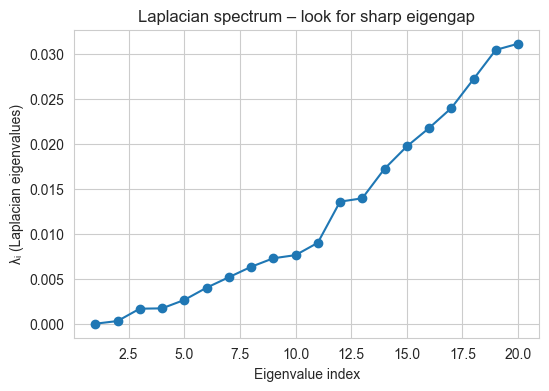

In [48]:
# plt.figure(figsize=(6,4))
# plt.plot(range(1, k+1), eigvals[:k], 'o-')
# plt.xlabel("Eigenvalue index")
# plt.ylabel("λᵢ (Laplacian eigenvalues)")
# plt.title("Laplacian spectrum – look for sharp eigengap")
# plt.grid(True)
# plt.show()
